In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_data =  pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')
test_data = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv')
sample_data = pd.read_csv('../input/demand-forecasting-kernels-only/sample_submission.csv')

In [4]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
train_data.shape

(913000, 4)

#### ANALYZING THE DATA

In [7]:
train_data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
train_data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [9]:
train_data[train_data.duplicated()]
## It checks for the duplicated data ..................

,date,store,item,sales


In [10]:
train_data['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [11]:
train_data.groupby('store').agg({'sales':['count','max','min','sum','mean','std']})

sales                                        
       count  max min      sum       mean        std
store                                               
1      91300  155   1  4315603  47.268379  24.006252
2      91300  231   3  6120128  67.033165  33.595810
3      91300  196   3  5435144  59.530602  29.974102
4      91300  186   4  5012639  54.902946  27.733097
5      91300  130   2  3631016  39.770164  20.365757
6      91300  134   0  3627670  39.733516  20.310451
7      91300  122   1  3320009  36.363735  18.684825
8      91300  204   4  5856169  64.142048  32.231751
9      91300  195   4  5025976  55.049025  27.832186
10     91300  187   3  5360158  58.709288  29.554994

In [12]:
train_data.groupby(['store'])[['item','sales']].nunique()

,item,sales
store,,
1,50,150
2,50,207
3,50,183
4,50,169
5,50,126
6,50,130
7,50,119
8,50,195
9,50,170


In [13]:
train_data.groupby(['store','item'])['sales'].sum()

store  item
1      1        36468
       2        97050
       3        60638
       4        36440
       5        30335
                ...  
10     46      120601
       47       45204
       48      105570
       49       60317
       50      135192
Name: sales, Length: 500, dtype: int64

In [14]:
train_data.groupby(['store','item'])['sales'].agg(['mean','sum','count','max','min','std'])

mean     sum  count  max  min        std
store item                                               
1     1     19.971522   36468   1826   50    4   6.741022
      2     53.148959   97050   1826  115   13  15.005779
      3     33.208105   60638   1826   70    8  10.072529
      4     19.956188   36440   1826   43    4   6.640618
      5     16.612815   30335   1826   37    3   5.672102
...               ...     ...    ...  ...  ...        ...
10    46    66.046550  120601   1826  125   23  18.114991
      47    24.755750   45204   1826   56    6   7.924820
      48    57.814896  105570   1826  120   21  15.898538
      49    33.032311   60317   1826   69    6  10.091610
      50    74.037240  135192   1826  150   24  19.937566

[500 rows x 6 columns]

In [15]:
train_data['date']= pd.to_datetime(train_data['date'])

In [16]:
type(train_data['date'])

pandas.core.series.Series

In [17]:
train_data['date'].nunique()
## So we have the data of intotal following days....................

1826

### Pre-processing

##### There might be some hidden patterns in our dataset that will not be revealed by the regular features.

##### They are cyclical patterns such as hours of the day, days of the week, months, seasons, etc.

In [18]:
train_data.groupby(['item'])['sales'].sum()

item
1      401384
2     1069564
3      669087
4      401907
5      335230
6     1068281
7     1068777
8     1405108
9      938379
10    1337133
11    1271925
12    1271534
13    1539621
14    1071531
15    1607442
16     468480
17     602486
18    1538876
19     736892
20     867641
21     736190
22    1469971
23     534979
24    1205975
25    1473334
26     869981
27     402628
28    1604713
29    1271240
30     736554
31    1070845
32     803107
33    1270183
34     469935
35    1201541
36    1406548
37     534258
38    1470330
39     801311
40     534094
41     401759
42     669925
43     936635
44     536811
45    1471467
46    1070764
47     401781
48     937703
49     535663
50    1203009
Name: sales, dtype: int64

### Creating indexes for better search

In [19]:
train_data.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [20]:
total_days = train_data['date'].nunique()
total_stores=train_data['store'].nunique()
total_items = train_data['item'].nunique()
total_items
indexes = []
for i in range(total_items*total_stores):
      indexes = indexes + np.linspace(0,total_days-1,total_days,dtype ='int').tolist()
len(indexes)


913000

In [21]:
train_data['index']= indexes
train_data.head()


,date,store,item,sales,index
0,2013-01-01,1,1,13,0
1,2013-01-02,1,1,11,1
2,2013-01-03,1,1,14,2
3,2013-01-04,1,1,13,3
4,2013-01-05,1,1,10,4


In [22]:
train_data['index'].nunique()

1826

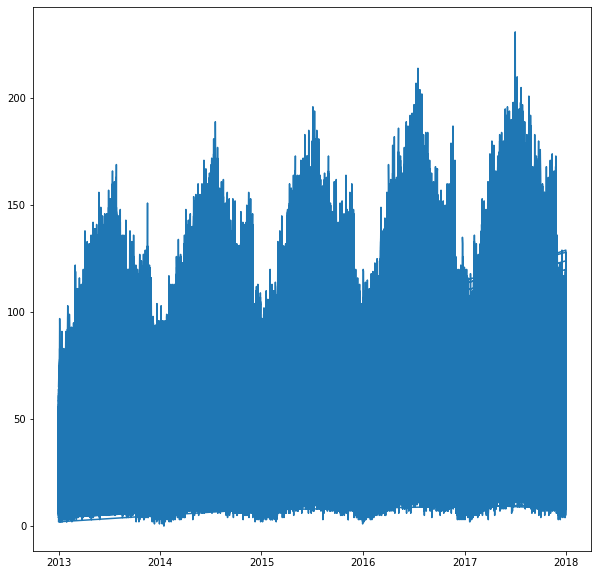

In [23]:
plt.figure(figsize=(10,10))
plt.plot(train_data['date'],train_data['sales'])


In [24]:
data = train_data.copy()

In [25]:
data['dayofweek'] = data.date.dt.dayofweek
data['quarter'] = data.date.dt.quarter
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
# data['dayofyear'] =data.date.dt.dayofyear
# data['dayofmonth'] = data.date.dt.day
# data['weekofyear'] = data.date.dt.isocalendar().week.astype("int64")

In [26]:
data.head()

,date,store,item,sales,index,dayofweek,quarter,month,year
0,2013-01-01,1,1,13,0,1,1,1,2013
1,2013-01-02,1,1,11,1,2,1,1,2013
2,2013-01-03,1,1,14,2,3,1,1,2013
3,2013-01-04,1,1,13,3,4,1,1,2013
4,2013-01-05,1,1,10,4,5,1,1,2013


In [27]:
# df = data.groupby(['dayofweek'])['sales'].a

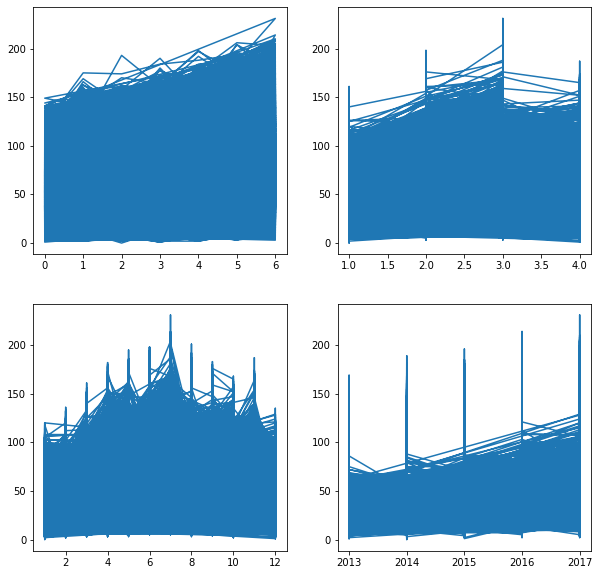

In [28]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].plot(data['dayofweek'],data['sales'])
ax[0,1].plot(data['quarter'],data['sales'])
ax[1,0].plot(data['month'],data['sales'])
ax[1,1].plot(data['year'],data['sales'])



#### Combining the both store and item columns  as time_series

In [29]:
data['store']= ['store_'+ str(i) for i in data['store']]
data['item'] = ['item_' + str(i) for i in data['item']]
data['time_series'] = data[['store','item']].apply(lambda x: '_'.join(x),axis=1)
data.head()

,date,store,item,sales,index,dayofweek,quarter,month,year,time_series
0,2013-01-01,store_1,item_1,13,0,1,1,1,2013,store_1_item_1
1,2013-01-02,store_1,item_1,11,1,2,1,1,2013,store_1_item_1
2,2013-01-03,store_1,item_1,14,2,3,1,1,2013,store_1_item_1
3,2013-01-04,store_1,item_1,13,3,4,1,1,2013,store_1_item_1
4,2013-01-05,store_1,item_1,10,4,5,1,1,2013,store_1_item_1


In [30]:
# Removing Unnecessary Columns:  'store', 'item'
data.drop(['store','item'],axis=1,inplace =True)

In [31]:
data['time_series'].nunique()

500

In [32]:
# Visualizing the different time series  with moving averages
import plotly.express as px


In [33]:
count= 0
for i in data['time_series'].unique():
    sub_data = data[data['time_series']==i] #it pick those rows which statisfy the given condition
    fig = px.line(sub_data,x= 'date', y= ['sales'], title =i)
    fig.show()
    count= count +1
    if (count==3 ):
        break  

### From the above graphs one can see the presence of yearly seasonality
#### Now we lets look for monthly seasonality too .... We will fix particular year and look for its months 

In [34]:
count =0
for i in data['time_series'].unique():
    for j in data['year'].unique():
        
        subdata = data[data['time_series']==i]
        subset = subdata[subdata['year']==j ]
        count+=1
        fig = px.line(subset,x='date',y= 'sales',title = i+'_'+str(j))
        fig.show()
        if(count==4):
            break
    break;



#### from the above graph we can easily conclude that selling of itmes first increases july, then start decreasing...So we can definitly for yearly seasonality

In [35]:
data['cosine'] = np.cos(2*np.pi*data['index']/365.25)
data.head()


,date,sales,index,dayofweek,quarter,month,year,time_series,cosine
0,2013-01-01,13,0,1,1,1,2013,store_1_item_1,1.000000
1,2013-01-02,11,1,2,1,1,2013,store_1_item_1,0.999852
2,2013-01-03,14,2,3,1,1,2013,store_1_item_1,0.999408
3,2013-01-04,13,3,4,1,1,2013,store_1_item_1,0.998669
4,2013-01-05,10,4,5,1,1,2013,store_1_item_1,0.997634


In [36]:
# data_train = data[data['year']!=2017]
# data_train.shape

In [37]:
# data_train.head()

In [38]:
from sklearn.linear_model import LinearRegression


In [39]:
import  pickle

In [40]:
# for i in data['time_series'].unique():
#     subData = data[data['time_series']==i]
#     sub_train = subData[subData['year']!=2017]
#     sub_test = subData[subData['year']==2017]  
#     X = np.array(sub_train['cosine']).reshape(-1, 1)
#     y = np.array(sub_train['sales']).reshape(-1, 1)
#     regression 
#     regression.fit(X,y)
    

In [41]:
# data_test =  data[data['year']==2017]
# x_test = data

In [42]:
reg = LinearRegression()

In [43]:
subData = data[data['time_series']=='store_1_item_1']
sub_train = subData[subData['year']!=2017]
sub_test = subData[subData['year']==2017]  
X = np.array(sub_train['cosine']).reshape(-1, 1)
y = np.array(sub_train['sales']).reshape(-1, 1)
reg.fit(X,y)

LinearRegression()

In [44]:
x_test = np.array(sub_test['cosine']).reshape(-1, 1)
y_pred =reg.predict(x_test)

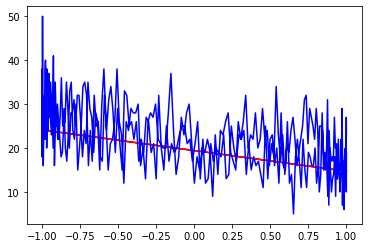

In [45]:
plt.plot(sub_test['cosine'],y_pred,'r')
plt.plot(sub_test['cosine'],sub_test['sales'],'b')


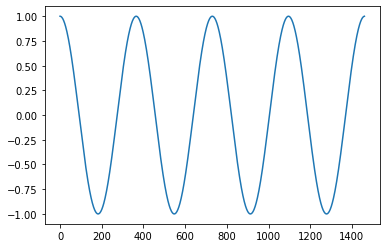

In [48]:
plt.plot(sub_train['cosine'])

In [66]:
# pip install --ignore-installed --pre pycaret

In [61]:
# !pip install pycaret

In [59]:
import pycaret

In [60]:
from tqdm import tqdm
from pycaret.regression import *

In [70]:
all_series = data['time_series'].unique()
results =[]
final_model ={}
for i in tqdm(all_series):
    
    data_subset = data[data['time_series']==i]
    
    stup = setup(data_subset, target = 'sales',train_size =0.8,
                 fold_strategy ='timeseries',fold =3,ignore_features = ['date','time_series'],
                 numeric_features=['index','year','month','dayofweek'],
                verbose = False ,session_id =123)
    
    best_model = compare_models(sort='MAE',verbose= False)
    
    #Capture the best model in list
    p = pull().iloc[0:1]
    p['time_series']= str(i)
    results.append(p)
    
    # finalize the model 
    f = finalize_model(best_model)
    
    # Making a dictionary
    final_model[i] = f
    filename = 'trained_models_' + str(i)+ '.pkl'
    pickle.dump(f,open(filename,'wb'))
#     save_model(f,model_name = 'trained_models/' + str(i),verbose =False)

100%|██████████| 500/500 [3:04:33<00:00, 22.15s/it]  


In [71]:
all_results = pd.concat(results,axis=0)
all_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
gbr,Gradient Boosting Regressor,3.6803,22.4999,4.7384,0.5338,0.2433,0.2131,0.0967,store_1_item_1
gbr,Gradient Boosting Regressor,4.5904,32.7457,5.7131,0.5796,0.2080,0.1810,0.0800,store_2_item_1
ridge,Ridge Regression,4.2152,27.9839,5.2889,0.5789,0.2160,0.1877,0.0367,store_3_item_1
lr,Linear Regression,3.9484,24.6434,4.9638,0.5591,0.2162,0.1887,0.0800,store_4_item_1
huber,Huber Regressor,3.3465,17.9778,4.2364,0.4603,0.2488,0.2239,0.0567,store_5_item_1


#### To implement the model, we have to create dataframe 

In [77]:
Dates = pd.date_range(start = '2013-01-01', end ='2019-12-31', freq='D')

In [78]:
df =  pd.DataFrame()
df['date'] =Dates
df['month']= [i.month for i in df['date']]
df['year'] = [i.year for i in df['date']]
df['dayofweek'] = [i.dayofweek for i in df['date']]
df['index'] = [i.dayofyear for i in df['date']]

df.head()

,date,month,year,dayofweek,index
0,2013-01-01,1,2013,1,1
1,2013-01-02,1,2013,2,2
2,2013-01-03,1,2013,3,3
3,2013-01-04,1,2013,4,4
4,2013-01-05,1,2013,5,5


In [86]:
df['quarter'] = [i.quarter for i in df['date']]
df['cosine'] = np.cos(2*np.pi*df['index']/365.25)

In [80]:
indexes = []
total_days = df['date'].nunique()
total_stores=train_data['store'].nunique()
total_items = train_data['item'].nunique()
for i in range(total_items*total_stores):
      indexes = indexes + np.linspace(0,total_days-1,total_days,dtype ='int').tolist()
len(indexes)

1278000

In [99]:
df.head()

,date,month,year,dayofweek,index,quarter,cosine
0,2013-01-01,1,2013,1,1,1,0.999852
1,2013-01-02,1,2013,2,2,1,0.999408
2,2013-01-03,1,2013,3,3,1,0.998669
3,2013-01-04,1,2013,4,4,1,0.997634
4,2013-01-05,1,2013,5,5,1,0.996303


In [89]:
from pycaret.regression import predict_model
all_score_df = []
for i in tqdm(data['time_series'].unique()):
    filename = 'trained_models_' + str(i) +'.pkl'
    l = pickle.load(open(filename,'rb'))
    p = predict_model(l, df)
    p['time_series'] = i
    all_score_df.append(p)
concat_df = pd.concat(all_score_df, axis=0)
concat_df.head()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<04:46,  1.74it/s]

  0%|          | 2/500 [00:01<04:32,  1.83it/s]

  1%|          | 3/500 [00:01<04:36,  1.80it/s]

  1%|          | 4/500 [00:02<04:37,  1.78it/s]

  1%|          | 5/500 [00:02<04:37,  1.78it/s]

  1%|          | 6/500 [00:03<04:37,  1.78it/s]

  1%|▏         | 7/500 [00:03<04:38,  1.77it/s]

  2%|▏         | 8/500 [00:04<04:34,  1.79it/s]

  2%|▏         | 9/500 [00:05<04:34,  1.79it/s]

  2%|▏         | 10/500 [00:05<04:30,  1.81it/s]

  2%|▏         | 11/500 [00:06<04:27,  1.82it/s]

  2%|▏         | 12/500 [00:06<04:25,  1.84it/s]

  3%|▎         | 13/500 [00:07<04:22,  1.85it/s]

  3%|▎         | 14/500 [00:07<04:23,  1.84it/s]

  3%|▎         | 15/500 [00:08<04:21,  1.85it/s]

  3%|▎         | 16/500 [00:08<04:20,  1.86it/s]

  3%|▎         | 17/500 [00:09<04:18,  1.87it/s]

  4%|▎         | 18/500 [00:09<04:17,  1.87it/s]

  4%|▍         | 19/500 [00:10<04:16,  1.87it/s]

  4%|▍         | 20/500 [00:10<04:14,  1.89it/s]

  4%|▍         | 21/500 [00:11<04:15,  1.87it/s]

  4%|▍         | 22/500 [00:11<04:12,  1.89it/s]

  5%|▍         | 23/500 [00:12<04:10,  1.90it/s]

  5%|▍         | 24/500 [00:13<04:08,  1.91it/s]

  5%|▌         | 25/500 [00:13<04:11,  1.89it/s]

  5%|▌         | 26/500 [00:14<04:09,  1.90it/s]

  5%|▌         | 27/500 [00:14<04:11,  1.88it/s]

  6%|▌         | 28/500 [00:15<04:11,  1.88it/s]

  6%|▌         | 29/500 [00:15<04:14,  1.85it/s]

  6%|▌         | 30/500 [00:16<04:12,  1.86it/s]

  6%|▌         | 31/500 [00:16<04:16,  1.83it/s]

  6%|▋         | 32/500 [00:17<04:20,  1.80it/s]

  7%|▋         | 33/500 [00:17<04:20,  1.79it/s]

  7%|▋         | 34/500 [00:18<04:16,  1.82it/s]

  7%|▋         | 35/500 [00:19<04:15,  1.82it/s]

  7%|▋         | 36/500 [00:19<04:17,  1.80it/s]

  7%|▋         | 37/500 [00:20<04:16,  1.81it/s]

  8%|▊         | 38/500 [00:20<04:10,  1.84it/s]

  8%|▊         | 39/500 [00:21<04:10,  1.84it/s]

  8%|▊         | 40/500 [00:21<04:10,  1.83it/s]

  8%|▊         | 41/500 [00:22<04:10,  1.83it/s]

  8%|▊         | 42/500 [00:22<04:08,  1.84it/s]

  9%|▊         | 43/500 [00:23<04:15,  1.79it/s]

  9%|▉         | 44/500 [00:23<04:10,  1.82it/s]

  9%|▉         | 45/500 [00:24<04:09,  1.83it/s]

  9%|▉         | 46/500 [00:25<04:08,  1.83it/s]

  9%|▉         | 47/500 [00:25<04:10,  1.81it/s]

 10%|▉         | 48/500 [00:26<04:11,  1.80it/s]

 10%|▉         | 49/500 [00:26<04:13,  1.78it/s]

 10%|█         | 50/500 [00:27<04:12,  1.78it/s]

 10%|█         | 51/500 [00:27<04:10,  1.79it/s]

 10%|█         | 52/500 [00:28<04:09,  1.80it/s]

 11%|█         | 53/500 [00:28<04:05,  1.82it/s]

 11%|█         | 54/500 [00:29<04:04,  1.83it/s]

 11%|█         | 55/500 [00:30<04:01,  1.84it/s]

 11%|█         | 56/500 [00:30<04:01,  1.84it/s]

 11%|█▏        | 57/500 [00:31<03:58,  1.86it/s]

 12%|█▏        | 58/500 [00:31<03:57,  1.86it/s]

 12%|█▏        | 59/500 [00:32<03:57,  1.86it/s]

 12%|█▏        | 60/500 [00:32<03:55,  1.87it/s]

 12%|█▏        | 61/500 [00:33<03:53,  1.88it/s]

 12%|█▏        | 62/500 [00:33<03:53,  1.88it/s]

 13%|█▎        | 63/500 [00:34<03:52,  1.88it/s]

 13%|█▎        | 64/500 [00:34<03:51,  1.88it/s]

 13%|█▎        | 65/500 [00:35<03:51,  1.88it/s]

 13%|█▎        | 66/500 [00:35<03:48,  1.90it/s]

 13%|█▎        | 67/500 [00:36<03:49,  1.89it/s]

 14%|█▎        | 68/500 [00:36<03:50,  1.87it/s]

 14%|█▍        | 69/500 [00:37<03:50,  1.87it/s]

 14%|█▍        | 70/500 [00:37<03:47,  1.89it/s]

 14%|█▍        | 71/500 [00:38<03:46,  1.90it/s]

 14%|█▍        | 72/500 [00:39<03:44,  1.90it/s]

 15%|█▍        | 73/500 [00:39<03:44,  1.90it/s]

 15%|█▍        | 74/500 [00:40<03:42,  1.91it/s]

 15%|█▌        | 75/500 [00:40<03:43,  1.91it/s]

 15%|█▌        | 76/500 [00:41<03:41,  1.91it/s]

 15%|█▌        | 77/500 [00:41<03:42,  1.90it/s]

 16%|█▌        | 78/500 [00:42<03:39,  1.92it/s]

 16%|█▌        | 79/500 [00:42<03:41,  1.90it/s]

 16%|█▌        | 80/500 [00:43<03:40,  1.91it/s]

 16%|█▌        | 81/500 [00:43<03:40,  1.90it/s]

 16%|█▋        | 82/500 [00:44<03:39,  1.90it/s]

 17%|█▋        | 83/500 [00:44<03:38,  1.91it/s]

 17%|█▋        | 84/500 [00:45<03:38,  1.91it/s]

 17%|█▋        | 85/500 [00:45<03:38,  1.90it/s]

 17%|█▋        | 86/500 [00:46<03:37,  1.90it/s]

 17%|█▋        | 87/500 [00:46<03:36,  1.91it/s]

 18%|█▊        | 88/500 [00:47<03:38,  1.88it/s]

 18%|█▊        | 89/500 [00:48<03:41,  1.86it/s]

 18%|█▊        | 90/500 [00:48<03:41,  1.85it/s]

 18%|█▊        | 91/500 [00:49<03:39,  1.86it/s]

 18%|█▊        | 92/500 [00:49<03:37,  1.88it/s]

 19%|█▊        | 93/500 [00:50<03:35,  1.89it/s]

 19%|█▉        | 94/500 [00:50<03:34,  1.89it/s]

 19%|█▉        | 95/500 [00:51<03:32,  1.91it/s]

 19%|█▉        | 96/500 [00:51<03:32,  1.90it/s]

 19%|█▉        | 97/500 [00:52<03:30,  1.91it/s]

 20%|█▉        | 98/500 [00:52<03:30,  1.91it/s]

 20%|█▉        | 99/500 [00:53<03:28,  1.92it/s]

 20%|██        | 100/500 [00:53<03:32,  1.88it/s]

 20%|██        | 101/500 [00:54<03:31,  1.88it/s]

 20%|██        | 102/500 [00:54<03:30,  1.89it/s]

 21%|██        | 103/500 [00:55<03:30,  1.88it/s]

 21%|██        | 104/500 [00:55<03:34,  1.85it/s]

 21%|██        | 105/500 [00:56<03:34,  1.84it/s]

 21%|██        | 106/500 [00:57<03:33,  1.85it/s]

 21%|██▏       | 107/500 [00:57<03:34,  1.83it/s]

 22%|██▏       | 108/500 [00:58<03:32,  1.85it/s]

 22%|██▏       | 109/500 [00:58<03:33,  1.83it/s]

 22%|██▏       | 110/500 [00:59<03:34,  1.82it/s]

 22%|██▏       | 111/500 [00:59<03:32,  1.83it/s]

 22%|██▏       | 112/500 [01:00<03:29,  1.86it/s]

 23%|██▎       | 113/500 [01:00<03:28,  1.85it/s]

 23%|██▎       | 114/500 [01:01<03:26,  1.87it/s]

 23%|██▎       | 115/500 [01:01<03:25,  1.87it/s]

 23%|██▎       | 116/500 [01:02<03:25,  1.87it/s]

 23%|██▎       | 117/500 [01:02<03:24,  1.87it/s]

 24%|██▎       | 118/500 [01:03<03:24,  1.87it/s]

 24%|██▍       | 119/500 [01:04<03:23,  1.87it/s]

 24%|██▍       | 120/500 [01:04<03:21,  1.89it/s]

 24%|██▍       | 121/500 [01:05<03:18,  1.91it/s]

 24%|██▍       | 122/500 [01:05<03:17,  1.91it/s]

 25%|██▍       | 123/500 [01:06<03:17,  1.91it/s]

 25%|██▍       | 124/500 [01:06<03:16,  1.91it/s]

 25%|██▌       | 125/500 [01:07<03:16,  1.91it/s]

 25%|██▌       | 126/500 [01:07<03:16,  1.91it/s]

 25%|██▌       | 127/500 [01:08<03:14,  1.91it/s]

 26%|██▌       | 128/500 [01:08<03:15,  1.90it/s]

 26%|██▌       | 129/500 [01:09<03:15,  1.90it/s]

 26%|██▌       | 130/500 [01:09<03:13,  1.91it/s]

 26%|██▌       | 131/500 [01:10<03:13,  1.91it/s]

 26%|██▋       | 132/500 [01:10<03:13,  1.90it/s]

 27%|██▋       | 133/500 [01:11<03:12,  1.91it/s]

 27%|██▋       | 134/500 [01:11<03:11,  1.91it/s]

 27%|██▋       | 135/500 [01:12<03:09,  1.92it/s]

 27%|██▋       | 136/500 [01:12<03:11,  1.90it/s]

 27%|██▋       | 137/500 [01:13<03:10,  1.91it/s]

 28%|██▊       | 138/500 [01:13<03:09,  1.91it/s]

 28%|██▊       | 139/500 [01:14<03:09,  1.91it/s]

 28%|██▊       | 140/500 [01:15<03:09,  1.90it/s]

 28%|██▊       | 141/500 [01:15<03:09,  1.90it/s]

 28%|██▊       | 142/500 [01:16<03:09,  1.89it/s]

 29%|██▊       | 143/500 [01:16<03:09,  1.88it/s]

 29%|██▉       | 144/500 [01:17<03:09,  1.88it/s]

 29%|██▉       | 145/500 [01:17<03:08,  1.88it/s]

 29%|██▉       | 146/500 [01:18<03:07,  1.89it/s]

 29%|██▉       | 147/500 [01:18<03:06,  1.89it/s]

 30%|██▉       | 148/500 [01:19<03:05,  1.90it/s]

 30%|██▉       | 149/500 [01:19<03:03,  1.91it/s]

 30%|███       | 150/500 [01:20<03:01,  1.93it/s]

 30%|███       | 151/500 [01:20<03:01,  1.92it/s]

 30%|███       | 152/500 [01:21<03:02,  1.91it/s]

 31%|███       | 153/500 [01:21<03:03,  1.89it/s]

 31%|███       | 154/500 [01:22<03:01,  1.91it/s]

 31%|███       | 155/500 [01:22<03:02,  1.89it/s]

 31%|███       | 156/500 [01:23<03:02,  1.88it/s]

 31%|███▏      | 157/500 [01:24<03:02,  1.88it/s]

 32%|███▏      | 158/500 [01:24<02:59,  1.91it/s]

 32%|███▏      | 159/500 [01:25<03:06,  1.83it/s]

 32%|███▏      | 160/500 [01:25<03:07,  1.81it/s]

 32%|███▏      | 161/500 [01:26<03:05,  1.83it/s]

 32%|███▏      | 162/500 [01:26<03:05,  1.82it/s]

 33%|███▎      | 163/500 [01:27<03:03,  1.83it/s]

 33%|███▎      | 164/500 [01:27<03:03,  1.83it/s]

 33%|███▎      | 165/500 [01:28<03:04,  1.81it/s]

 33%|███▎      | 166/500 [01:29<03:07,  1.78it/s]

 33%|███▎      | 167/500 [01:29<03:07,  1.78it/s]

 34%|███▎      | 168/500 [01:30<03:04,  1.80it/s]

 34%|███▍      | 169/500 [01:30<03:02,  1.82it/s]

 34%|███▍      | 170/500 [01:31<03:02,  1.81it/s]

 34%|███▍      | 171/500 [01:31<03:01,  1.81it/s]

 34%|███▍      | 172/500 [01:32<02:58,  1.83it/s]

 35%|███▍      | 173/500 [01:32<02:58,  1.83it/s]

 35%|███▍      | 174/500 [01:33<02:59,  1.82it/s]

 35%|███▌      | 175/500 [01:33<02:57,  1.84it/s]

 35%|███▌      | 176/500 [01:34<02:55,  1.84it/s]

 35%|███▌      | 177/500 [01:35<02:54,  1.85it/s]

 36%|███▌      | 178/500 [01:35<02:53,  1.85it/s]

 36%|███▌      | 179/500 [01:36<02:52,  1.86it/s]

 36%|███▌      | 180/500 [01:36<02:53,  1.84it/s]

 36%|███▌      | 181/500 [01:37<02:51,  1.86it/s]

 36%|███▋      | 182/500 [01:37<02:52,  1.85it/s]

 37%|███▋      | 183/500 [01:38<02:49,  1.87it/s]

 37%|███▋      | 184/500 [01:38<02:48,  1.88it/s]

 37%|███▋      | 185/500 [01:39<02:47,  1.88it/s]

 37%|███▋      | 186/500 [01:39<02:45,  1.90it/s]

 37%|███▋      | 187/500 [01:40<02:45,  1.89it/s]

 38%|███▊      | 188/500 [01:40<02:43,  1.90it/s]

 38%|███▊      | 189/500 [01:41<02:43,  1.90it/s]

 38%|███▊      | 190/500 [01:41<02:42,  1.90it/s]

 38%|███▊      | 191/500 [01:42<02:42,  1.90it/s]

 38%|███▊      | 192/500 [01:42<02:41,  1.91it/s]

 39%|███▊      | 193/500 [01:43<02:41,  1.90it/s]

 39%|███▉      | 194/500 [01:44<02:40,  1.91it/s]

 39%|███▉      | 195/500 [01:44<02:39,  1.91it/s]

 39%|███▉      | 196/500 [01:45<02:39,  1.90it/s]

 39%|███▉      | 197/500 [01:45<02:39,  1.90it/s]

 40%|███▉      | 198/500 [01:46<02:38,  1.90it/s]

 40%|███▉      | 199/500 [01:46<02:38,  1.90it/s]

 40%|████      | 200/500 [01:47<02:37,  1.90it/s]

 40%|████      | 201/500 [01:47<02:40,  1.86it/s]

 40%|████      | 202/500 [01:48<02:40,  1.86it/s]

 41%|████      | 203/500 [01:48<02:38,  1.87it/s]

 41%|████      | 204/500 [01:49<02:37,  1.88it/s]

 41%|████      | 205/500 [01:49<02:37,  1.87it/s]

 41%|████      | 206/500 [01:50<02:35,  1.89it/s]

 41%|████▏     | 207/500 [01:50<02:33,  1.91it/s]

 42%|████▏     | 208/500 [01:51<02:32,  1.92it/s]

 42%|████▏     | 209/500 [01:51<02:30,  1.93it/s]

 42%|████▏     | 210/500 [01:52<02:30,  1.93it/s]

 42%|████▏     | 211/500 [01:52<02:28,  1.94it/s]

 42%|████▏     | 212/500 [01:53<02:28,  1.94it/s]

 43%|████▎     | 213/500 [01:53<02:29,  1.93it/s]

 43%|████▎     | 214/500 [01:54<02:28,  1.92it/s]

 43%|████▎     | 215/500 [01:55<02:27,  1.93it/s]

 43%|████▎     | 216/500 [01:55<02:27,  1.92it/s]

 43%|████▎     | 217/500 [01:56<02:27,  1.92it/s]

 44%|████▎     | 218/500 [01:56<02:29,  1.89it/s]

 44%|████▍     | 219/500 [01:57<02:28,  1.89it/s]

 44%|████▍     | 220/500 [01:57<02:29,  1.87it/s]

 44%|████▍     | 221/500 [01:58<02:28,  1.88it/s]

 44%|████▍     | 222/500 [01:58<02:27,  1.88it/s]

 45%|████▍     | 223/500 [01:59<02:30,  1.85it/s]

 45%|████▍     | 224/500 [01:59<02:28,  1.86it/s]

 45%|████▌     | 225/500 [02:00<02:30,  1.83it/s]

 45%|████▌     | 226/500 [02:00<02:29,  1.83it/s]

 45%|████▌     | 227/500 [02:01<02:27,  1.85it/s]

 46%|████▌     | 228/500 [02:02<02:26,  1.86it/s]

 46%|████▌     | 229/500 [02:02<02:27,  1.84it/s]

 46%|████▌     | 230/500 [02:03<02:25,  1.85it/s]

 46%|████▌     | 231/500 [02:03<02:25,  1.85it/s]

 46%|████▋     | 232/500 [02:04<02:24,  1.86it/s]

 47%|████▋     | 233/500 [02:04<02:23,  1.86it/s]

 47%|████▋     | 234/500 [02:05<02:22,  1.86it/s]

 47%|████▋     | 235/500 [02:05<02:21,  1.87it/s]

 47%|████▋     | 236/500 [02:06<02:20,  1.88it/s]

 47%|████▋     | 237/500 [02:06<02:18,  1.89it/s]

 48%|████▊     | 238/500 [02:07<02:18,  1.89it/s]

 48%|████▊     | 239/500 [02:07<02:19,  1.87it/s]

 48%|████▊     | 240/500 [02:08<02:18,  1.88it/s]

 48%|████▊     | 241/500 [02:08<02:18,  1.88it/s]

 48%|████▊     | 242/500 [02:09<02:17,  1.88it/s]

 49%|████▊     | 243/500 [02:10<02:16,  1.89it/s]

 49%|████▉     | 244/500 [02:10<02:15,  1.89it/s]

 49%|████▉     | 245/500 [02:11<02:13,  1.91it/s]

 49%|████▉     | 246/500 [02:11<02:13,  1.91it/s]

 49%|████▉     | 247/500 [02:12<02:13,  1.90it/s]

 50%|████▉     | 248/500 [02:12<02:12,  1.90it/s]

 50%|████▉     | 249/500 [02:13<02:11,  1.91it/s]

 50%|█████     | 250/500 [02:13<02:11,  1.90it/s]

 50%|█████     | 251/500 [02:14<02:11,  1.89it/s]

 50%|█████     | 252/500 [02:14<02:10,  1.89it/s]

 51%|█████     | 253/500 [02:15<02:10,  1.89it/s]

 51%|█████     | 254/500 [02:15<02:10,  1.89it/s]

 51%|█████     | 255/500 [02:16<02:11,  1.86it/s]

 51%|█████     | 256/500 [02:16<02:11,  1.86it/s]

 51%|█████▏    | 257/500 [02:17<02:13,  1.82it/s]

 52%|█████▏    | 258/500 [02:18<02:13,  1.82it/s]

 52%|█████▏    | 259/500 [02:18<02:11,  1.84it/s]

 52%|█████▏    | 260/500 [02:19<02:09,  1.85it/s]

 52%|█████▏    | 261/500 [02:19<02:10,  1.83it/s]

 52%|█████▏    | 262/500 [02:20<02:09,  1.83it/s]

 53%|█████▎    | 263/500 [02:20<02:07,  1.86it/s]

 53%|█████▎    | 264/500 [02:21<02:07,  1.85it/s]

 53%|█████▎    | 265/500 [02:21<02:05,  1.87it/s]

 53%|█████▎    | 266/500 [02:22<02:06,  1.85it/s]

 53%|█████▎    | 267/500 [02:22<02:05,  1.85it/s]

 54%|█████▎    | 268/500 [02:23<02:05,  1.85it/s]

 54%|█████▍    | 269/500 [02:23<02:05,  1.84it/s]

 54%|█████▍    | 270/500 [02:24<02:05,  1.84it/s]

 54%|█████▍    | 271/500 [02:25<02:03,  1.86it/s]

 54%|█████▍    | 272/500 [02:25<02:01,  1.88it/s]

 55%|█████▍    | 273/500 [02:26<02:00,  1.89it/s]

 55%|█████▍    | 274/500 [02:26<01:59,  1.89it/s]

 55%|█████▌    | 275/500 [02:27<01:59,  1.89it/s]

 55%|█████▌    | 276/500 [02:27<02:05,  1.78it/s]

 55%|█████▌    | 277/500 [02:28<02:05,  1.78it/s]

 56%|█████▌    | 278/500 [02:28<02:02,  1.81it/s]

 56%|█████▌    | 279/500 [02:29<02:01,  1.82it/s]

 56%|█████▌    | 280/500 [02:29<02:00,  1.82it/s]

 56%|█████▌    | 281/500 [02:30<02:00,  1.82it/s]

 56%|█████▋    | 282/500 [02:31<01:59,  1.82it/s]

 57%|█████▋    | 283/500 [02:31<01:58,  1.82it/s]

 57%|█████▋    | 284/500 [02:32<01:57,  1.83it/s]

 57%|█████▋    | 285/500 [02:32<01:57,  1.83it/s]

 57%|█████▋    | 286/500 [02:33<01:57,  1.82it/s]

 57%|█████▋    | 287/500 [02:33<01:57,  1.82it/s]

 58%|█████▊    | 288/500 [02:34<01:55,  1.83it/s]

 58%|█████▊    | 289/500 [02:34<01:54,  1.84it/s]

 58%|█████▊    | 290/500 [02:35<01:53,  1.85it/s]

 58%|█████▊    | 291/500 [02:35<01:53,  1.85it/s]

 58%|█████▊    | 292/500 [02:36<01:53,  1.83it/s]

 59%|█████▊    | 293/500 [02:37<01:53,  1.83it/s]

 59%|█████▉    | 294/500 [02:37<01:54,  1.79it/s]

 59%|█████▉    | 295/500 [02:38<01:56,  1.76it/s]

 59%|█████▉    | 296/500 [02:38<01:55,  1.77it/s]

 59%|█████▉    | 297/500 [02:39<01:52,  1.80it/s]

 60%|█████▉    | 298/500 [02:39<01:51,  1.82it/s]

 60%|█████▉    | 299/500 [02:40<01:49,  1.83it/s]

 60%|██████    | 300/500 [02:40<01:48,  1.85it/s]

 60%|██████    | 301/500 [02:41<01:46,  1.87it/s]

 60%|██████    | 302/500 [02:41<01:45,  1.88it/s]

 61%|██████    | 303/500 [02:42<01:44,  1.89it/s]

 61%|██████    | 304/500 [02:43<01:43,  1.90it/s]

 61%|██████    | 305/500 [02:43<01:42,  1.90it/s]

 61%|██████    | 306/500 [02:44<01:42,  1.90it/s]

 61%|██████▏   | 307/500 [02:44<01:42,  1.89it/s]

 62%|██████▏   | 308/500 [02:45<01:41,  1.89it/s]

 62%|██████▏   | 309/500 [02:45<01:40,  1.90it/s]

 62%|██████▏   | 310/500 [02:46<01:39,  1.91it/s]

 62%|██████▏   | 311/500 [02:46<01:40,  1.87it/s]

 62%|██████▏   | 312/500 [02:47<01:40,  1.87it/s]

 63%|██████▎   | 313/500 [02:47<01:40,  1.86it/s]

 63%|██████▎   | 314/500 [02:48<01:39,  1.86it/s]

 63%|██████▎   | 315/500 [02:48<01:38,  1.87it/s]

 63%|██████▎   | 316/500 [02:49<01:37,  1.88it/s]

 63%|██████▎   | 317/500 [02:49<01:36,  1.90it/s]

 64%|██████▎   | 318/500 [02:50<01:35,  1.91it/s]

 64%|██████▍   | 319/500 [02:50<01:34,  1.92it/s]

 64%|██████▍   | 320/500 [02:51<01:33,  1.93it/s]

 64%|██████▍   | 321/500 [02:51<01:32,  1.93it/s]

 64%|██████▍   | 322/500 [02:52<01:32,  1.93it/s]

 65%|██████▍   | 323/500 [02:53<01:31,  1.94it/s]

 65%|██████▍   | 324/500 [02:53<01:30,  1.94it/s]

 65%|██████▌   | 325/500 [02:54<01:30,  1.93it/s]

 65%|██████▌   | 326/500 [02:54<01:29,  1.93it/s]

 65%|██████▌   | 327/500 [02:55<01:29,  1.93it/s]

 66%|██████▌   | 328/500 [02:55<01:29,  1.92it/s]

 66%|██████▌   | 329/500 [02:56<01:29,  1.91it/s]

 66%|██████▌   | 330/500 [02:56<01:29,  1.91it/s]

 66%|██████▌   | 331/500 [02:57<01:30,  1.87it/s]

 66%|██████▋   | 332/500 [02:57<01:30,  1.86it/s]

 67%|██████▋   | 333/500 [02:58<01:30,  1.84it/s]

 67%|██████▋   | 334/500 [02:58<01:31,  1.80it/s]

 67%|██████▋   | 335/500 [02:59<01:34,  1.74it/s]

 67%|██████▋   | 336/500 [03:00<01:33,  1.75it/s]

 67%|██████▋   | 337/500 [03:00<01:33,  1.75it/s]

 68%|██████▊   | 338/500 [03:01<01:31,  1.78it/s]

 68%|██████▊   | 339/500 [03:01<01:29,  1.80it/s]

 68%|██████▊   | 340/500 [03:02<01:28,  1.80it/s]

 68%|██████▊   | 341/500 [03:02<01:27,  1.81it/s]

 68%|██████▊   | 342/500 [03:03<01:27,  1.81it/s]

 69%|██████▊   | 343/500 [03:03<01:26,  1.82it/s]

 69%|██████▉   | 344/500 [03:04<01:25,  1.82it/s]

 69%|██████▉   | 345/500 [03:05<01:24,  1.84it/s]

 69%|██████▉   | 346/500 [03:05<01:22,  1.86it/s]

 69%|██████▉   | 347/500 [03:06<01:22,  1.86it/s]

 70%|██████▉   | 348/500 [03:06<01:21,  1.87it/s]

 70%|██████▉   | 349/500 [03:07<01:20,  1.87it/s]

 70%|███████   | 350/500 [03:07<01:20,  1.86it/s]

 70%|███████   | 351/500 [03:08<01:20,  1.85it/s]

 70%|███████   | 352/500 [03:08<01:19,  1.85it/s]

 71%|███████   | 353/500 [03:09<01:18,  1.87it/s]

 71%|███████   | 354/500 [03:09<01:17,  1.87it/s]

 71%|███████   | 355/500 [03:10<01:17,  1.87it/s]

 71%|███████   | 356/500 [03:10<01:17,  1.87it/s]

 71%|███████▏  | 357/500 [03:11<01:16,  1.87it/s]

 72%|███████▏  | 358/500 [03:11<01:15,  1.89it/s]

 72%|███████▏  | 359/500 [03:12<01:14,  1.90it/s]

 72%|███████▏  | 360/500 [03:12<01:12,  1.92it/s]

 72%|███████▏  | 361/500 [03:13<01:13,  1.89it/s]

 72%|███████▏  | 362/500 [03:14<01:12,  1.90it/s]

 73%|███████▎  | 363/500 [03:14<01:12,  1.89it/s]

 73%|███████▎  | 364/500 [03:15<01:12,  1.87it/s]

 73%|███████▎  | 365/500 [03:15<01:12,  1.85it/s]

 73%|███████▎  | 366/500 [03:16<01:12,  1.85it/s]

 73%|███████▎  | 367/500 [03:16<01:11,  1.85it/s]

 74%|███████▎  | 368/500 [03:17<01:11,  1.85it/s]

 74%|███████▍  | 369/500 [03:17<01:10,  1.85it/s]

 74%|███████▍  | 370/500 [03:18<01:09,  1.86it/s]

 74%|███████▍  | 371/500 [03:18<01:09,  1.86it/s]

 74%|███████▍  | 372/500 [03:19<01:08,  1.87it/s]

 75%|███████▍  | 373/500 [03:19<01:07,  1.89it/s]

 75%|███████▍  | 374/500 [03:20<01:06,  1.89it/s]

 75%|███████▌  | 375/500 [03:21<01:05,  1.90it/s]

 75%|███████▌  | 376/500 [03:21<01:05,  1.90it/s]

 75%|███████▌  | 377/500 [03:22<01:04,  1.89it/s]

 76%|███████▌  | 378/500 [03:22<01:04,  1.89it/s]

 76%|███████▌  | 379/500 [03:23<01:03,  1.90it/s]

 76%|███████▌  | 380/500 [03:23<01:02,  1.91it/s]

 76%|███████▌  | 381/500 [03:24<01:02,  1.91it/s]

 76%|███████▋  | 382/500 [03:24<01:01,  1.91it/s]

 77%|███████▋  | 383/500 [03:25<01:01,  1.90it/s]

 77%|███████▋  | 384/500 [03:25<01:01,  1.88it/s]

 77%|███████▋  | 385/500 [03:26<01:01,  1.88it/s]

 77%|███████▋  | 386/500 [03:26<01:00,  1.88it/s]

 77%|███████▋  | 387/500 [03:27<01:00,  1.88it/s]

 78%|███████▊  | 388/500 [03:27<00:59,  1.87it/s]

 78%|███████▊  | 389/500 [03:28<00:59,  1.87it/s]

 78%|███████▊  | 390/500 [03:28<00:58,  1.86it/s]

 78%|███████▊  | 391/500 [03:29<00:58,  1.88it/s]

 78%|███████▊  | 392/500 [03:30<00:57,  1.86it/s]

 79%|███████▊  | 393/500 [03:30<00:57,  1.85it/s]

 79%|███████▉  | 394/500 [03:31<00:59,  1.80it/s]

 79%|███████▉  | 395/500 [03:31<00:58,  1.79it/s]

 79%|███████▉  | 396/500 [03:32<00:57,  1.80it/s]

 79%|███████▉  | 397/500 [03:32<00:57,  1.79it/s]

 80%|███████▉  | 398/500 [03:33<00:56,  1.82it/s]

 80%|███████▉  | 399/500 [03:33<00:54,  1.85it/s]

 80%|████████  | 400/500 [03:34<00:53,  1.86it/s]

 80%|████████  | 401/500 [03:35<00:53,  1.84it/s]

 80%|████████  | 402/500 [03:35<00:52,  1.87it/s]

 81%|████████  | 403/500 [03:36<00:52,  1.86it/s]

 81%|████████  | 404/500 [03:36<00:51,  1.85it/s]

 81%|████████  | 405/500 [03:37<00:50,  1.87it/s]

 81%|████████  | 406/500 [03:37<00:50,  1.84it/s]

 81%|████████▏ | 407/500 [03:38<00:50,  1.84it/s]

 82%|████████▏ | 408/500 [03:38<00:50,  1.82it/s]

 82%|████████▏ | 409/500 [03:39<00:49,  1.84it/s]

 82%|████████▏ | 410/500 [03:39<00:49,  1.83it/s]

 82%|████████▏ | 411/500 [03:40<00:48,  1.85it/s]

 82%|████████▏ | 412/500 [03:40<00:47,  1.86it/s]

 83%|████████▎ | 413/500 [03:41<00:46,  1.88it/s]

 83%|████████▎ | 414/500 [03:41<00:45,  1.89it/s]

 83%|████████▎ | 415/500 [03:42<00:45,  1.86it/s]

 83%|████████▎ | 416/500 [03:43<00:44,  1.87it/s]

 83%|████████▎ | 417/500 [03:43<00:44,  1.87it/s]

 84%|████████▎ | 418/500 [03:44<00:43,  1.87it/s]

 84%|████████▍ | 419/500 [03:44<00:43,  1.85it/s]

 84%|████████▍ | 420/500 [03:45<00:43,  1.86it/s]

 84%|████████▍ | 421/500 [03:45<00:42,  1.87it/s]

 84%|████████▍ | 422/500 [03:46<00:41,  1.88it/s]

 85%|████████▍ | 423/500 [03:46<00:40,  1.89it/s]

 85%|████████▍ | 424/500 [03:47<00:40,  1.89it/s]

 85%|████████▌ | 425/500 [03:47<00:40,  1.87it/s]

 85%|████████▌ | 426/500 [03:48<00:39,  1.87it/s]

 85%|████████▌ | 427/500 [03:48<00:38,  1.88it/s]

 86%|████████▌ | 428/500 [03:49<00:38,  1.89it/s]

 86%|████████▌ | 429/500 [03:49<00:37,  1.91it/s]

 86%|████████▌ | 430/500 [03:50<00:36,  1.92it/s]

 86%|████████▌ | 431/500 [03:50<00:35,  1.92it/s]

 86%|████████▋ | 432/500 [03:51<00:35,  1.93it/s]

 87%|████████▋ | 433/500 [03:52<00:34,  1.93it/s]

 87%|████████▋ | 434/500 [03:52<00:34,  1.93it/s]

 87%|████████▋ | 435/500 [03:53<00:33,  1.94it/s]

 87%|████████▋ | 436/500 [03:53<00:33,  1.90it/s]

 87%|████████▋ | 437/500 [03:54<00:33,  1.91it/s]

 88%|████████▊ | 438/500 [03:54<00:32,  1.91it/s]

 88%|████████▊ | 439/500 [03:55<00:32,  1.91it/s]

 88%|████████▊ | 440/500 [03:55<00:31,  1.89it/s]

 88%|████████▊ | 441/500 [03:56<00:31,  1.89it/s]

 88%|████████▊ | 442/500 [03:56<00:30,  1.89it/s]

 89%|████████▊ | 443/500 [03:57<00:30,  1.89it/s]

 89%|████████▉ | 444/500 [03:57<00:29,  1.87it/s]

 89%|████████▉ | 445/500 [03:58<00:29,  1.87it/s]

 89%|████████▉ | 446/500 [03:58<00:28,  1.87it/s]

 89%|████████▉ | 447/500 [03:59<00:28,  1.87it/s]

 90%|████████▉ | 448/500 [03:59<00:27,  1.89it/s]

 90%|████████▉ | 449/500 [04:00<00:27,  1.89it/s]

 90%|█████████ | 450/500 [04:01<00:26,  1.88it/s]

 90%|█████████ | 451/500 [04:01<00:26,  1.87it/s]

 90%|█████████ | 452/500 [04:02<00:26,  1.84it/s]

 91%|█████████ | 453/500 [04:02<00:25,  1.85it/s]

 91%|█████████ | 454/500 [04:03<00:24,  1.84it/s]

 91%|█████████ | 455/500 [04:03<00:24,  1.84it/s]

 91%|█████████ | 456/500 [04:04<00:23,  1.86it/s]

 91%|█████████▏| 457/500 [04:04<00:22,  1.87it/s]

 92%|█████████▏| 458/500 [04:05<00:22,  1.87it/s]

 92%|█████████▏| 459/500 [04:05<00:21,  1.88it/s]

 92%|█████████▏| 460/500 [04:06<00:21,  1.88it/s]

 92%|█████████▏| 461/500 [04:06<00:21,  1.84it/s]

 92%|█████████▏| 462/500 [04:07<00:20,  1.84it/s]

 93%|█████████▎| 463/500 [04:08<00:20,  1.85it/s]

 93%|█████████▎| 464/500 [04:08<00:19,  1.85it/s]

 93%|█████████▎| 465/500 [04:09<00:19,  1.84it/s]

 93%|█████████▎| 466/500 [04:09<00:18,  1.84it/s]

 93%|█████████▎| 467/500 [04:10<00:18,  1.83it/s]

 94%|█████████▎| 468/500 [04:10<00:17,  1.83it/s]

 94%|█████████▍| 469/500 [04:11<00:17,  1.82it/s]

 94%|█████████▍| 470/500 [04:11<00:16,  1.85it/s]

 94%|█████████▍| 471/500 [04:12<00:15,  1.87it/s]

 94%|█████████▍| 472/500 [04:12<00:14,  1.89it/s]

 95%|█████████▍| 473/500 [04:13<00:14,  1.90it/s]

 95%|█████████▍| 474/500 [04:13<00:13,  1.90it/s]

 95%|█████████▌| 475/500 [04:14<00:13,  1.90it/s]

 95%|█████████▌| 476/500 [04:15<00:12,  1.90it/s]

 95%|█████████▌| 477/500 [04:15<00:12,  1.90it/s]

 96%|█████████▌| 478/500 [04:16<00:11,  1.90it/s]

 96%|█████████▌| 479/500 [04:16<00:11,  1.88it/s]

 96%|█████████▌| 480/500 [04:17<00:10,  1.86it/s]

 96%|█████████▌| 481/500 [04:17<00:10,  1.81it/s]

 96%|█████████▋| 482/500 [04:18<00:09,  1.81it/s]

 97%|█████████▋| 483/500 [04:18<00:09,  1.82it/s]

 97%|█████████▋| 484/500 [04:19<00:08,  1.84it/s]

 97%|█████████▋| 485/500 [04:19<00:08,  1.86it/s]

 97%|█████████▋| 486/500 [04:20<00:07,  1.83it/s]

 97%|█████████▋| 487/500 [04:21<00:07,  1.81it/s]

 98%|█████████▊| 488/500 [04:21<00:06,  1.82it/s]

 98%|█████████▊| 489/500 [04:22<00:06,  1.82it/s]

 98%|█████████▊| 490/500 [04:22<00:05,  1.85it/s]

 98%|█████████▊| 491/500 [04:23<00:04,  1.86it/s]

 98%|█████████▊| 492/500 [04:23<00:04,  1.87it/s]

 99%|█████████▊| 493/500 [04:24<00:03,  1.87it/s]

 99%|█████████▉| 494/500 [04:24<00:03,  1.87it/s]

 99%|█████████▉| 495/500 [04:25<00:02,  1.86it/s]

 99%|█████████▉| 496/500 [04:25<00:02,  1.86it/s]

 99%|█████████▉| 497/500 [04:26<00:01,  1.87it/s]

100%|█████████▉| 498/500 [04:26<00:01,  1.87it/s]

100%|█████████▉| 499/500 [04:27<00:00,  1.87it/s]

100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


,index,dayofweek,quarter,month,year,cosine,prediction_label,time_series
0,1.0,1.0,1.0,1.0,2013.0,0.999852,10.467855,store_1_item_1
1,2.0,2.0,1.0,1.0,2013.0,0.999408,11.188929,store_1_item_1
2,3.0,3.0,1.0,1.0,2013.0,0.998669,11.200632,store_1_item_1
3,4.0,4.0,1.0,1.0,2013.0,0.997634,11.810347,store_1_item_1
4,5.0,5.0,1.0,1.0,2013.0,0.996303,11.788085,store_1_item_1


m 


In [93]:
# list = []
# oon = 62.2
# oon['ssd'] ='s'
# list.append(oon)

In [114]:
concat_df.shape

(1278000, 8)

In [113]:
temp = []
for i in data['time_series'].unique():
    temp = temp + np.array(Dates).tolist()
len(temp)    
    

1278000

In [117]:
concat_df['date'] = temp
concat_df['date'] = pd.to_datetime(concat_df['date'])

In [120]:
final_data =  pd.merge(concat_df,data,how = 'left',left_on=['date','time_series'],right_on= ['date','time_series'])
final_data.head()

,index_x,dayofweek_x,quarter_x,month_x,year_x,cosine_x,prediction_label,time_series,date,sales,index_y,dayofweek_y,quarter_y,month_y,year_y,cosine_y
0,1.0,1.0,1.0,1.0,2013.0,0.999852,10.467855,store_1_item_1,2013-01-01,13.0,0.0,1.0,1.0,1.0,2013.0,1.000000
1,2.0,2.0,1.0,1.0,2013.0,0.999408,11.188929,store_1_item_1,2013-01-02,11.0,1.0,2.0,1.0,1.0,2013.0,0.999852
2,3.0,3.0,1.0,1.0,2013.0,0.998669,11.200632,store_1_item_1,2013-01-03,14.0,2.0,3.0,1.0,1.0,2013.0,0.999408
3,4.0,4.0,1.0,1.0,2013.0,0.997634,11.810347,store_1_item_1,2013-01-04,13.0,3.0,4.0,1.0,1.0,2013.0,0.998669
4,5.0,5.0,1.0,1.0,2013.0,0.996303,11.788085,store_1_item_1,2013-01-05,10.0,4.0,5.0,1.0,1.0,2013.0,0.997634


In [121]:
for i in final_data['time_series'].unique()[:5]:
    sub_df = final_data[final_data['time_series'] == i]
    
#     import plotly.express as px
    fig = px.line(sub_df, x="date", y=['sales', 'prediction_label'], title=i)
    fig.show()
    
 

In [124]:
sample_Subm = pd.read_csv('../input/demand-forecasting-kernels-only/sample_submission.csv')

In [150]:
sample_Subm.head()

,id,sales
0,0,10.164822
1,1,10.277629
2,2,10.910816
3,3,10.434116
4,4,11.639103


In [127]:
sample_Subm.shape

(45000, 2)

In [146]:
final_sales =[]
for i in final_data['time_series'].unique():
    subset = final_data[final_data['time_series']==i]
    subdata = subset[final_data['year_x']==2018]
    final_sales = final_sales + np.array(subdata['prediction_label'][:90]).tolist()
len(final_sales)

45000

In [148]:
sample_Subm['sales'] = final_sales

In [149]:
sample_Subm.head()

,id,sales
0,0,10.164822
1,1,10.277629
2,2,10.910816
3,3,10.434116
4,4,11.639103


In [151]:
sample_Subm.to_csv('my_Submission.csv')